In [1]:
import pandas as pd
import numpy as np

from plotly.graph_objs import Bar, Figure, Scatter, Histogram
import plotly


from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype


#%%
def reduce_mem_usage(df, use_float16=False):
    """
    Original function code is from:
        https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08


    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    # print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    # print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    # print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

def load_data(filepath):
    """
    Import data from database into a DataFrame. Split DataFrame into
    features and predictors, `X` and `Y`.

    Preprocess data.

    Params:
    -------
        database_filepath: file path of database

    Returns:
    --------
        pd.DataFrame; (X, Y, df, category_names)
        Features and predictors, `X` and `Y`, respectively.
        Original DataFrame, `df`, and named of target labels
    """
    df = pd.read_csv(filepath)


    return df

In [15]:
# load predictions DataFrame
preds_df = load_data('../models/final_preds_df.csv')
# preds_df = reduce_mem_usage(preds_df)

# load data
df = load_data('../data/clean_data.csv')
df = reduce_mem_usage(df)

In [68]:
# plot predictions
def make_sample_df(df, date_range=('2017-01', '2017-03')):
    """
    Create new sample DataFrame with sample meter readings, and new
    timestamp given `date_range`.
    """
    df_new = pd.DataFrame()
    df_new['timestamp'] = np.arange(date_range[0], date_range[1], dtype='datetime64[D]')

    # get number of samples
    n_samples = df_new.shape[0]

    # sample from original DF
    df.reset_index(drop=True, inplace=True)
    df_new['meter_reading'] = df['meter_reading'].sample(n_samples).values
    # set new index to `timestamp`
    df_new = df_new.set_index('timestamp')

    return df_new

def make_sample_plot(df, date_range=('2017-01', '2017-03'), resample='D'):
    df_new = make_sample_df(df, date_range)
    df_new = df_new.resample(resample).mean()
    df_new['meter_reading'].plot(
        kind='line',
        label='TS Plot',
        legend=True,
        linewidth=2
    )

def make_time_series(df):
    """
    Convert input DataFrame to time series.

    """
    dt_format = "%Y-%m-%d %H:%M:%S"
    df['timestamp'] = pd.to_datetime(df['timestamp'],
                                     format=dt_format)
    return df.set_index('timestamp')


def plot_predictions(df, date_range=("2017-01-01", "2017-12-31")):
    """


    Params:
    --------
        df : DataFrame
            DataFrame to use for plotting.

        date_range : tuple, optional
            The default is ("2017-01-01", "2017-12-31") which the based on
            the test DataFrame and the predictions are made for these dates.

    Returns:
    --------
        fig : Plotly Figure


    """
    # # get plot for predictions
    # df_new = make_sample_df(df)

    # time-series prediction data
    df_new = make_time_series(df)
    
    # resample to daily average
    df_new = df_new.resample('D').mean()

    # define x and y
    y = df_new['meter_reading'].values
    x = df_new.index

    # new figure
    fig = Figure([Scatter(x=x,
                          y=y,
                          name='Predictions',
                          line=dict(color='royalblue',
                                    width=2))
                    ])

    # Edit layout
    fig.update_layout(title='Predictions',
                      yaxis_title='kWh',
                      plot_bgcolor='white',

                      yaxis=dict(
                          gridcolor='rgb(225, 225, 225)',
                          gridwidth=0.25,
                          
                          linecolor='rgb(100, 100, 100)',
                          linewidth=2,
                          
                          showticklabels=True,
                          color='black'
                      ),
                      xaxis=dict(
                          
                          gridcolor='rgb(225, 225, 225)',
                          gridwidth=0.25,
                          
                          linecolor='rgb(100, 100, 100)',
                          linewidth=2,
                          
                          ticks='outside',
                          tickfont=dict(
                              family='Arial',
                              size=12,
                              color='rgb(82, 82, 82)',
                          ),
                      )
                     )
    # Use date string to set xaxis range
    fig.update_layout(
        xaxis_range=[date_range[0], date_range[1]],
        )

    return fig

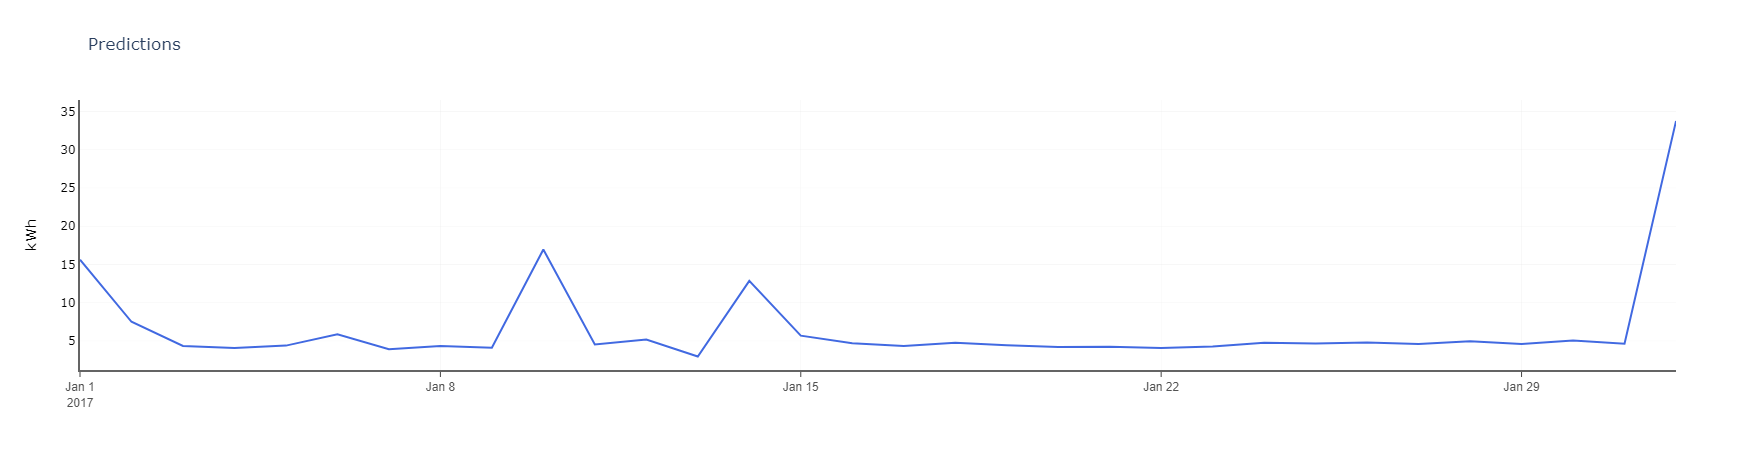

In [69]:
plot_predictions(preds_df, date_range=('2017-01-01', '2017-06-01'))